# Deep Learning

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
import plotly
import tensorflow as tf
import random
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from optuna.integration import TFKerasPruningCallback
from optuna.visualization import plot_optimization_history, plot_param_importances


seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

plt.rcParams["figure.figsize"] = [10, 6]

## Data Preparation

In [3]:
# Load the data
merged_df = (
    pd.read_csv(
        "../data/merged_df.csv", parse_dates=["timestamp"], index_col="timestamp"
    )
    .sort_index()
    .convert_dtypes()
)
arima_predictions_T = (pd.read_csv('../data/arima_predictions_T.csv', parse_dates=['timestamp'], index_col='timestamp')
                       .sort_index()
                       .convert_dtypes())
arima_predictions_V = (pd.read_csv('../data/arima_predictions_VZ.csv', parse_dates=['timestamp'], index_col='timestamp')
                       .sort_index()
                       .convert_dtypes())

In [4]:
merged_df.head(10)

,close_t,close_v,weekday_name,market_holiday,t_diff,v_diff
timestamp,,,,,,
2019-01-02,29.54,56.02,Wednesday,False,0.0,0.0
2019-01-03,29.58,56.22,Thursday,False,0.04,0.2
2019-01-04,30.34,56.36,Friday,False,0.76,0.14
2019-01-05,30.34,56.36,Saturday,False,0.0,0.0
2019-01-06,30.34,56.36,Sunday,False,0.0,0.0
2019-01-07,30.89,56.72,Monday,False,0.55,0.36
2019-01-08,31.28,58.38,Tuesday,False,0.39,1.66
2019-01-09,30.1,57.05,Wednesday,False,-1.18,-1.33
2019-01-10,30.4,57.6,Thursday,False,0.3,0.55


In [5]:
# Feature scaling
scaler_t = MinMaxScaler(feature_range=(0, 1))
scaler_v = MinMaxScaler(feature_range=(0, 1))

# Reshape data to 2D arrays as required by MinMaxScaler
merged_df["t_scaled"] = scaler_t.fit_transform(
    merged_df["t_diff"].values.reshape(-1, 1)
)
merged_df["v_scaled"] = scaler_v.fit_transform(
    merged_df["v_diff"].values.reshape(-1, 1)
)

In [28]:
merged_df.t_scaled.head()

timestamp
2019-01-02    0.503949
2019-01-03    0.510269
2019-01-04    0.624013
2019-01-05    0.503949
2019-01-06    0.503949
Name: t_scaled, dtype: float64

In [6]:
# Create separate datasets out of the time series.
t_data = merged_df['t_scaled'].values
v_data = merged_df['v_scaled'].values

# Make sure we can use the same split point for both datasets
assert len(t_data) == len(v_data)

# Creating split points to maintain temporal integrity
split_point = int(len(t_data) * 0.95)

t_train_data, t_test_data = t_data[:split_point], t_data[split_point:]
v_train_data, v_test_data = v_data[:split_point], v_data[split_point:]


In [7]:
# Create a function to split the dataset into sub-sequences
def create_dataset(data: np.ndarray, window_size: int) -> tuple:
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)


In [8]:
# Reshape the data
n_steps = 10
n_features = 1

t_X_train, t_y_train = create_dataset(t_train_data, n_steps)
t_X_train = t_X_train.reshape(t_X_train.shape[0], t_X_train.shape[1], n_features)

t_X_test, t_y_test = create_dataset(t_test_data, n_steps)
t_X_test = t_X_test.reshape(t_X_test.shape[0], t_X_test.shape[1], n_features)

v_X_train, v_y_train = create_dataset(v_train_data, n_steps)
v_X_train = v_X_train.reshape(v_X_train.shape[0], v_X_train.shape[1], n_features)

v_X_test, v_y_test = create_dataset(v_test_data, n_steps)
v_X_test = v_X_test.reshape(v_X_test.shape[0], v_X_test.shape[1], n_features)


In [32]:
print(t_X_train.shape, t_y_train.shape)
print(v_X_train.shape, v_y_train.shape)

(827, 10, 1) (827,)
(827, 10, 1) (827,)


## Implementing an RNN model
### AT&T Stock Price Prediction

In [33]:
def objective(trial):
    # Define the hyperparameter search space
    n_units = trial.suggest_int("n_units", 20, 200)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    window_size = trial.suggest_int("window_size", 5, 30)

    # Re-create the dataset with the current window_size
    X_train, y_train = create_dataset(t_train_data, window_size)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    X_val, y_val = create_dataset(t_test_data, window_size)
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    # Build the model
    model = Sequential()
    model.add(SimpleRNN(units=n_units, activation="tanh", input_shape=(window_size, 1)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1))

    # Compile the model
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mean_squared_error")

    # Define Early Stopping
    early_stop = EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, TFKerasPruningCallback(trial, "val_loss")],
        verbose=0,  # Suppress training output for cleaner Optuna logs
    )

    # Evaluate the model on validation data
    val_loss = history.history["val_loss"][-1]

    return val_loss

In [ ]:
warnings.filterwarnings("ignore")

# Create the Optuna study
study = optuna.create_study(
    direction="minimize", study_name="SimpleRNN Hyperparameter Optimization"
)
study.optimize(
    objective, n_trials=50, timeout=600
)  # Adjust n_trials and timeout as needed

# Display the best trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-01-17 15:36:45,094] A new study created in memory with name: SimpleRNN Hyperparameter Optimization


2025-01-17 15:36:45.310679: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
[I 2025-01-17 15:36:56,896] Trial 0 finished with value: 0.008349504321813583 and parameters: {'n_units': 189, 'dropout_rate': 0.4370581922762573, 'learning_rate': 0.007369712152728976, 'batch_size': 16, 'window_size': 29}. Best is trial 0 with value: 0.008349504321813583.
[I 2025-01-17 15:36:59,074] Trial 1 finished with value: 0.005865920800715685 and parameters: {'n_units': 143, 'dropout_rate': 0.4403194483045942, 'learning_rate': 1.3202711470495564e-05, 'batch_size': 16, 'window_size': 17}. Best is trial 1 with value: 0.005865920800715685.
[I 2025-01-17 15:37:05,926] Trial 2 finished with value: 0.008603308349847794 and parameters: {'n_units': 185, 'dropout_rate': 0.1537412990288563, 'learning_rate': 0.001803095931849199, 'batch_size': 32, 'window_size': 27}. Best is trial 1 with value: 0.005865920800715685.
[I 2025-01-17 15:37:07,605] Trial 3 finished with value:

[I 2025-01-17 15:37:15,496] Trial 9 finished with value: 0.006715416442602873 and parameters: {'n_units': 144, 'dropout_rate': 0.08367337509332862, 'learning_rate': 0.0001773412111813362, 'batch_size': 16, 'window_size': 13}. Best is trial 4 with value: 0.005820725578814745.
[I 2025-01-17 15:37:16,008] Trial 10 pruned. Trial was pruned at epoch 0.
[I 2025-01-17 15:37:16,567] Trial 11 pruned. Trial was pruned at epoch 0.
[I 2025-01-17 15:37:17,089] Trial 12 pruned. Trial was pruned at epoch 0.


[I 2025-01-17 15:37:17,619] Trial 13 pruned. Trial was pruned at epoch 0.
[I 2025-01-17 15:37:18,185] Trial 14 pruned. Trial was pruned at epoch 0.
[I 2025-01-17 15:37:18,704] Trial 15 pruned. Trial was pruned at epoch 0.
[I 2025-01-17 15:37:19,227] Trial 16 pruned. Trial was pruned at epoch 0.
[I 2025-01-17 15:37:20,366] Trial 17 finished with value: 0.004113285336643457 and parameters: {'n_units': 137, 'dropout_rate': 0.22197095719080398, 'learning_rate': 2.471515404024836e-05, 'batch_size': 32, 'window_size': 8}. Best is trial 17 with value: 0.004113285336643457.
[I 2025-01-17 15:37:20,881] Trial 18 pruned. Trial was pruned at epoch 0.
[I 2025-01-17 15:37:21,629] Trial 19 pruned. Trial was pruned at epoch 0.
[I 2025-01-17 15:37:22,728] Trial 20 finished with value: 0.005505301058292389 and parameters: {'n_units': 115, 'dropout_rate': 0.15402832381138518, 'learning_rate': 0.0003831487823387726, 'batch_size': 32, 'window_size': 8}. Best is trial 17 with value: 0.004113285336643457.
[I

Number of finished trials:  50
Best trial:
  Value: 0.004113285336643457
  Params: 
    n_units: 137
    dropout_rate: 0.22197095719080398
    learning_rate: 2.471515404024836e-05
    batch_size: 32
    window_size: 8


In [35]:
# Retrieve best hyperparameters
best_params = study.best_trial.params

# Extract hyperparameters
best_n_units = best_params["n_units"]
best_dropout_rate = best_params["dropout_rate"]
best_learning_rate = best_params["learning_rate"]
best_batch_size = best_params["batch_size"]
best_window_size = best_params["window_size"]

# Prepare the dataset with the best window size
X_train_best, y_train_best = create_dataset(t_train_data, best_window_size)
X_train_best = X_train_best.reshape((X_train_best.shape[0], X_train_best.shape[1], 1))

X_val_best, y_val_best = create_dataset(t_test_data, best_window_size)
X_val_best = X_val_best.reshape((X_val_best.shape[0], X_val_best.shape[1], 1))

# Build the final model with best hyperparameters
final_model = Sequential()
final_model.add(
    SimpleRNN(units=best_n_units, activation="tanh", input_shape=(best_window_size, 1))
)
final_model.add(Dropout(rate=best_dropout_rate))
final_model.add(Dense(1))

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=best_learning_rate)
final_model.compile(optimizer=optimizer, loss="mean_squared_error")

# Define Early Stopping
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the final model
history = final_model.fit(
    X_train_best,
    y_train_best,
    epochs=100,
    batch_size=best_batch_size,
    validation_data=(X_val_best, y_val_best),
    callbacks=[early_stop],
    verbose=1,
)

# Evaluate the final model
test_loss = final_model.evaluate(X_val_best, y_val_best)
print(f"Final Model Test Mean Squared Error: {test_loss}")

Epoch 1/100
26/26 [==============================] - 0s 6ms/step - loss: 0.0746 - val_loss: 0.0106
Epoch 2/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0073
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0069
Epoch 4/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0207 - val_loss: 0.0070
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0205 - val_loss: 0.0070
Epoch 6/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0186 - val_loss: 0.0070
Epoch 7/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0184 - val_loss: 0.0070
Epoch 8/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0174 - val_loss: 0.0071
Epoch 9/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0163 - val_loss: 0.0071
Epoch 10/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0071
Epoch 11/

2/2 [==============================] - 0s 1ms/step


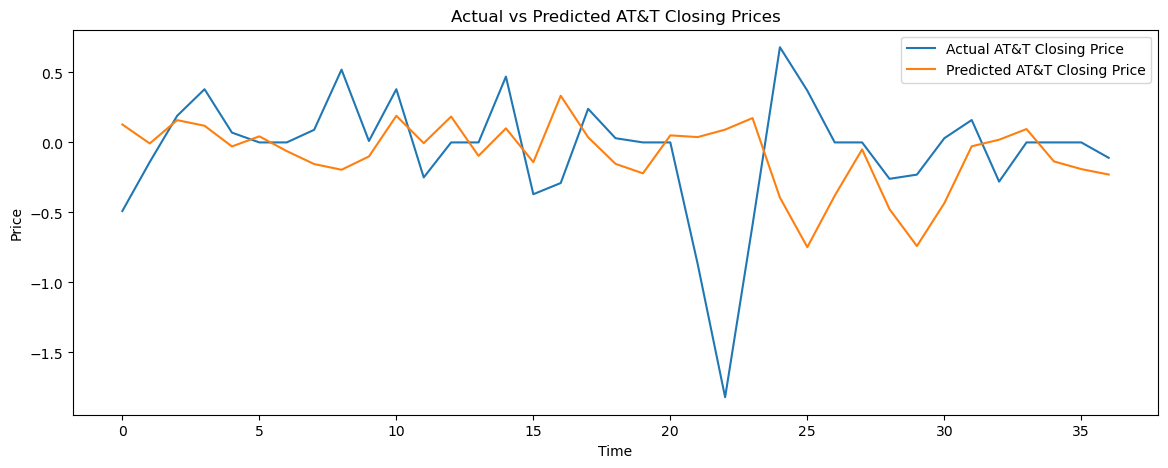

In [36]:
# Make predictions on test data
y_pred_best = final_model.predict(X_val_best)

# Inverse transform the scaled data
t_y_test_actual = scaler_t.inverse_transform(y_val_best.reshape(-1, 1))
t_y_pred_actual = scaler_t.inverse_transform(y_pred_best)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(t_y_test_actual, label="Actual AT&T Closing Price")
plt.plot(t_y_pred_actual, label="Predicted AT&T Closing Price")
plt.title("Actual vs Predicted AT&T Closing Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
# I want to encapsulate this into a class
# The class will accept transformed data and:
# 1. Conduct an Optuna hyperparameter search and save the best hyperparameters with an .optimize() method -- DONE
# 2. Train the model with the best hyperparameters with a .train() method
# 3. Plot the training and validation loss with a .plot_loss() method
# 4. Predict on the test data with a .predict() method
# 5. Plot the actual vs predicted values with a .plot_predictions() method

class SimpleRNNModel:
    def __init__(self, data, n_steps, n_features, name):
        self.data = data
        self.n_steps = n_steps
        self.n_features = n_features
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.name = name

    def create_dataset(self, data_scaled: np.ndarray, window_size: int) -> tuple:
        X, y = [], []
        for i in range(len(data_scaled) - window_size):
            X.append(data_scaled[i : (i + window_size)])
            y.append(data_scaled[i + window_size])
        return np.array(X), np.array(y)

    def scale_split(self, split_ratio=0.95):
        self.data_scaled = self.scaler.fit_transform(self.data.values.reshape(-1, 1))
        split_point = int(len(self.data_scaled) * split_ratio)
        self.train_data, self.test_data = self.data_scaled[:split_point], self.data_scaled[split_point:]

    def optimize(self, n_trials=50, timeout=600):
        def objective(trial):
            # Define the hyperparameter search space
            n_units = trial.suggest_int("n_units", 20, 200)
            dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
            learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
            batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
            window_size = trial.suggest_int("window_size", 5, 30)

            if self.train_data is None:
                raise ValueError("Please scale and split the data first.")
            else:
                # Re-create the dataset with the current window_size
                X_train, y_train = create_dataset(self.train_data, window_size)
                X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

                X_val, y_val = create_dataset(self.test_data, window_size)
                X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

            # Build the model
            model = Sequential()
            model.add(SimpleRNN(units=n_units, activation="tanh", input_shape=(window_size, 1)))
            model.add(Dropout(rate=dropout_rate))
            model.add(Dense(1))

            # Compile the model
            optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, loss="mean_squared_error")

            # Define Early Stopping
            early_stop = EarlyStopping(
                monitor="val_loss", patience=10, restore_best_weights=True
            )

            # Train the model
            history = model.fit(
                X_train,
                y_train,
                epochs=100,
                batch_size=batch_size,
                validation_data=(X_val, y_val),
                callbacks=[early_stop, TFKerasPruningCallback(trial, "val_loss")],
                verbose=0,  # Suppress training output for cleaner Optuna logs
            )

            # Evaluate the model on validation data
            self.val_loss = history.history["val_loss"][-1]

            return self.val_loss

        warnings.filterwarnings("ignore")

        # Create the Optuna study
        study = optuna.create_study(
            direction="minimize", study_name="SimpleRNN Hyperparameter Optimization"
        )
        study.optimize(
            objective, n_trials=n_trials, timeout=timeout
        )

        # Retrieve best hyperparameters
        self.best_params = study.best_trial.params

        # Extract hyperparameters
        self.best_n_units = self.best_params["n_units"]
        self.best_dropout_rate = self.best_params["dropout_rate"]
        self.best_learning_rate = self.best_params["learning_rate"]
        self.best_batch_size = self.best_params["batch_size"]
        self.best_window_size = self.best_params["window_size"]

        # Display the best trial
        print("Number of finished trials: ", len(study.trials))
        print("Best trial:")
        trial = study.best_trial

        print("  Value: {}".format(trial.value))
        print("  Params: ")
        for key, value in trial.params.items():
            print("    {}: {}".format(key, value))

        # Plot optimization history
        fig1 = plot_optimization_history(study)
        fig1.show()

        # Plot parameter importances
        fig2 = plot_param_importances(study)
        fig2.show()

    def train(self):
        # Prepare the dataset with the best window size
        self.X_train_best, self.y_train_best = create_dataset(self.train_data, self.best_window_size)
        self.X_train_best = self.X_train_best.reshape((self.X_train_best.shape[0], self.X_train_best.shape[1], 1))

        self.X_val_best, self.y_val_best = create_dataset(self.test_data, self.best_window_size)
        self.X_val_best = self.X_val_best.reshape((self.X_val_best.shape[0], self.X_val_best.shape[1], 1))

        # Build the final model with best hyperparameters
        self.final_model = Sequential()
        self.final_model.add(
            SimpleRNN(units=self.best_n_units, activation="tanh", input_shape=(self.best_window_size, 1))
        )
        self.final_model.add(Dropout(rate=self.best_dropout_rate))
        self.final_model.add(Dense(1))

        # Compile the model
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=self.best_learning_rate)
        self.final_model.compile(optimizer=optimizer, loss="mean_squared_error")

        # Define Early Stopping
        early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

        # Train the final model
        history = self.final_model.fit(
            self.X_train_best,
            self.y_train_best,
            epochs=100,
            batch_size=self.best_batch_size,
            validation_data=(self.X_val_best, self.y_val_best),
            callbacks=[early_stop],
            verbose=1,
        )
        
        self.history = history

        # Evaluate the final model
        self.test_loss = self.final_model.evaluate(self.X_val_best, self.y_val_best)
        print(f"Final Model Test Mean Squared Error: {self.test_loss}")
        
    def plot_loss(self) -> None:
        plt.figure(figsize=(10, 5))
        plt.plot(self.history.history["loss"], label="Training Loss")
        plt.plot(self.history.history["val_loss"], label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"{self.name} Training and Validation Loss")
        plt.legend()
        plt.show()

    def plot_predictions(self):
        # Make predictions on test data
        self.y_pred_best = self.final_model.predict(self.X_val_best)

        # Inverse transform the scaled data
        self.v_y_test_actual = self.scaler.inverse_transform(self.y_val_best.reshape(-1, 1))
        self.v_y_pred_actual = self.scaler.inverse_transform(self.y_pred_best)

        # Plot the results
        plt.figure(figsize=(14, 5))
        plt.plot(self.v_y_test_actual, label=f"Actual {self.name} Closing Price")
        plt.plot(self.v_y_pred_actual, label=f"Predicted {self.name} Closing Price")
        plt.title(f"Actual vs Predicted {self.name} Closing Prices")
        plt.xlabel("Timestamp")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

[I 2025-01-18 08:27:30,792] A new study created in memory with name: SimpleRNN Hyperparameter Optimization
[I 2025-01-18 08:27:31,882] Trial 0 finished with value: 0.01219338458031416 and parameters: {'n_units': 54, 'dropout_rate': 0.21862679747334746, 'learning_rate': 4.3700932967358824e-05, 'batch_size': 64, 'window_size': 22}. Best is trial 0 with value: 0.01219338458031416.
[I 2025-01-18 08:27:33,089] Trial 1 finished with value: 0.012641502544283867 and parameters: {'n_units': 86, 'dropout_rate': 0.059465970077144825, 'learning_rate': 0.00018050092407133448, 'batch_size': 128, 'window_size': 24}. Best is trial 0 with value: 0.01219338458031416.
[I 2025-01-18 08:27:36,204] Trial 2 finished with value: 0.008980765007436275 and parameters: {'n_units': 98, 'dropout_rate': 0.31596932566801145, 'learning_rate': 0.00016733877169385457, 'batch_size': 64, 'window_size': 24}. Best is trial 2 with value: 0.008980765007436275.


Number of finished trials:  3
Best trial:
  Value: 0.008980765007436275
  Params: 
    n_units: 98
    dropout_rate: 0.31596932566801145
    learning_rate: 0.00016733877169385457
    batch_size: 64
    window_size: 24


Epoch 1/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0551 - val_loss: 0.0084
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0313 - val_loss: 0.0098
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0229 - val_loss: 0.0087
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0190 - val_loss: 0.0086
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0174 - val_loss: 0.0087
Epoch 6/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0094
Epoch 7/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0150 - val_loss: 0.0080
Epoch 8/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0132 - val_loss: 0.0078
Epoch 9/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0131 - val_loss: 0.0071
Epoch 10/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0072
Epoch 11

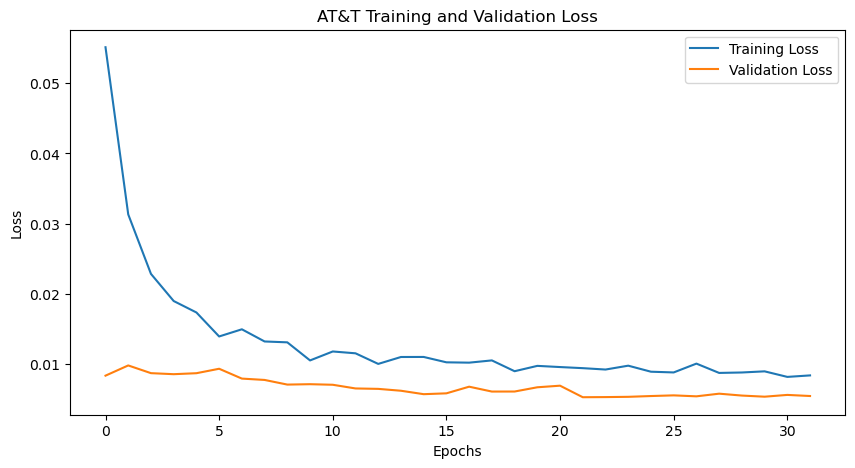

1/1 [==============================] - 0s 70ms/step


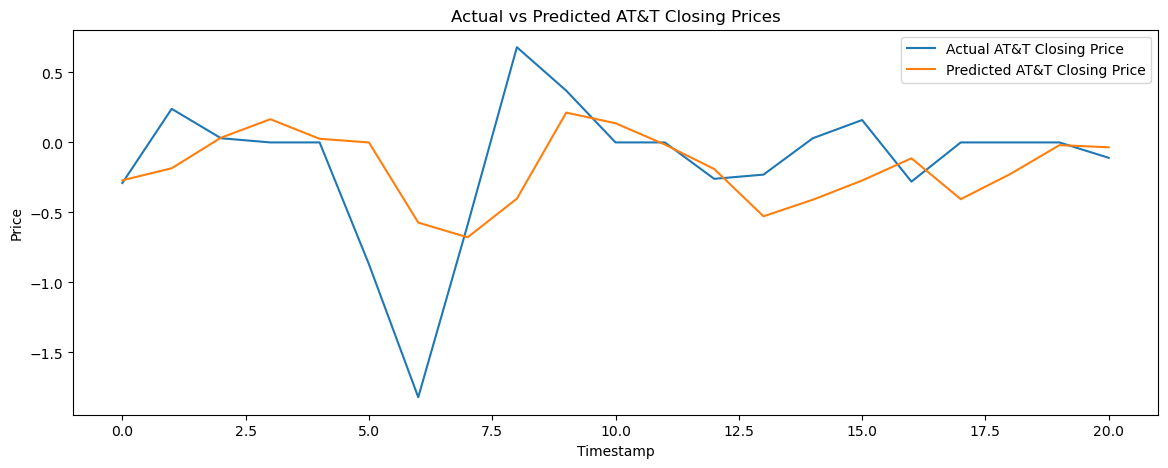

In [13]:
rnn_t = SimpleRNNModel(merged_df['t_diff'], n_steps=10, n_features=1, name='AT&T')
rnn_t.scale_split()
rnn_t.optimize(n_trials=3)
rnn_t.train()
rnn_t.plot_loss()

assert rnn_t.X_train_best.all() == t_X_train.all()
assert rnn_t.y_train_best.all() == t_y_train.all()
assert rnn_t.X_val_best.all() == t_X_test.all()
assert rnn_t.y_val_best.all() == t_y_test.all()
assert rnn_t.train_data.all() == t_train_data.all()
assert rnn_t.test_data.all() == t_test_data.all()

rnn_t.plot_predictions()

### Verizon Stock Price Prediction

In [72]:
def objective_v(trial):
    # Define the hyperparameter search space
    n_units = trial.suggest_int("n_units", 20, 200)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    window_size = trial.suggest_int("window_size", 5, 30)

    # Re-create the dataset with the current window_size
    X_train, y_train = create_dataset(v_train_data, window_size)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    X_val, y_val = create_dataset(v_test_data, window_size)
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    # Build the model
    model = Sequential()
    model.add(SimpleRNN(units=n_units, activation="tanh", input_shape=(window_size, 1)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1))

    # Compile the model
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mean_squared_error")

    # Define Early Stopping
    early_stop = EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, TFKerasPruningCallback(trial, "val_loss")],
        verbose=0,
    )

    # Evaluate the model on validation data
    val_loss = history.history["val_loss"][-1]

    return val_loss

In [73]:
# Create the Optuna study for Verizon
study_v = optuna.create_study(
    direction="minimize", study_name="SimpleRNN_V Hyperparameter Optimization"
)
study_v.optimize(objective_v, n_trials=50, timeout=600)  # Adjust as needed

# Display the best trial for Verizon
print("Number of finished trials for Verizon: ", len(study_v.trials))
print("Best trial for Verizon:")
trial_v = study_v.best_trial

print("  Value: {}".format(trial_v.value))
print("  Params: ")
for key, value in trial_v.params.items():
    print("    {}: {}".format(key, value))

[I 2025-01-16 22:11:06,360] A new study created in memory with name: SimpleRNN_V Hyperparameter Optimization
[I 2025-01-16 22:11:11,297] Trial 0 finished with value: 0.003017967799678445 and parameters: {'n_units': 68, 'dropout_rate': 0.18210452457255444, 'learning_rate': 1.9289802229857107e-05, 'batch_size': 16, 'window_size': 5}. Best is trial 0 with value: 0.003017967799678445.
[I 2025-01-16 22:11:15,119] Trial 1 finished with value: 0.0032533735502511263 and parameters: {'n_units': 195, 'dropout_rate': 0.10936504888453835, 'learning_rate': 0.0004157840491054802, 'batch_size': 16, 'window_size': 22}. Best is trial 0 with value: 0.003017967799678445.
[I 2025-01-16 22:11:17,063] Trial 2 finished with value: 0.0014373167650774121 and parameters: {'n_units': 72, 'dropout_rate': 0.21422405310193854, 'learning_rate': 0.0011544444308668736, 'batch_size': 128, 'window_size': 30}. Best is trial 2 with value: 0.0014373167650774121.
[I 2025-01-16 22:11:19,169] Trial 3 finished with value: 0.00

Number of finished trials for Verizon:  50
Best trial for Verizon:
  Value: 0.0013337725540623069
  Params: 
    n_units: 198
    dropout_rate: 0.13695913109987162
    learning_rate: 0.00019947646408335145
    batch_size: 16
    window_size: 30


In [74]:
# Retrieve best hyperparameters
best_params = study_v.best_trial.params

# Extract hyperparameters
best_n_units = best_params["n_units"]
best_dropout_rate = best_params["dropout_rate"]
best_learning_rate = best_params["learning_rate"]
best_batch_size = best_params["batch_size"]
best_window_size = best_params["window_size"]

# Prepare the dataset with the best window size
X_train_best, y_train_best = create_dataset(t_train_data, best_window_size)
X_train_best = X_train_best.reshape((X_train_best.shape[0], X_train_best.shape[1], 1))

X_val_best, y_val_best = create_dataset(t_test_data, best_window_size)
X_val_best = X_val_best.reshape((X_val_best.shape[0], X_val_best.shape[1], 1))

# Build the final model with best hyperparameters
final_model = Sequential()
final_model.add(
    SimpleRNN(units=best_n_units, activation="tanh", input_shape=(best_window_size, 1))
)
final_model.add(Dropout(rate=best_dropout_rate))
final_model.add(Dense(1))

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=best_learning_rate)
final_model.compile(optimizer=optimizer, loss="mean_squared_error")

# Define Early Stopping
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the final model
history = final_model.fit(
    X_train_best,
    y_train_best,
    epochs=100,
    batch_size=best_batch_size,
    validation_data=(X_val_best, y_val_best),
    callbacks=[early_stop],
    verbose=1,
)

# Evaluate the final model
test_loss = final_model.evaluate(X_val_best, y_val_best)
print(f"Final Model Test Mean Squared Error: {test_loss}")

Epoch 1/100
51/51 [==============================] - 1s 8ms/step - loss: 0.0200 - val_loss: 0.0075
Epoch 2/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0078
Epoch 3/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0076 - val_loss: 0.0072
Epoch 4/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0113
Epoch 5/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0073 - val_loss: 0.0110
Epoch 6/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 7/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0066 - val_loss: 0.0086
Epoch 8/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0070 - val_loss: 0.0093
Epoch 9/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0089
Epoch 10/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0092
Epoch 11/

1/1 [==============================] - 0s 13ms/step


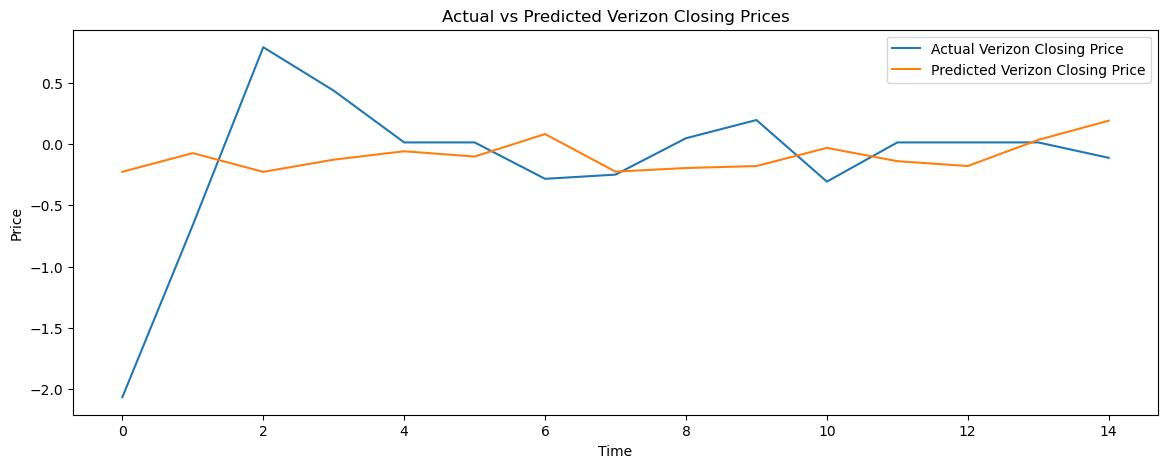

In [76]:
# Make predictions on test data
y_pred_best = final_model.predict(X_val_best)

# Inverse transform the scaled data
v_y_test_actual = scaler_v.inverse_transform(y_val_best.reshape(-1, 1))
v_y_pred_actual = scaler_v.inverse_transform(y_pred_best)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(v_y_test_actual, label="Actual Verizon Closing Price")
plt.plot(v_y_pred_actual, label="Predicted Verizon Closing Price")
plt.title("Actual vs Predicted Verizon Closing Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()